In [5]:

# ✅ STEP 1: Install Required Libraries (Only once)
!pip install scikit-learn seaborn --quiet

# ✅ STEP 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")


In [7]:
# Sample intern data
intern_df = pd.DataFrame({
    'Intern_Name': ['Ali', 'Sara', 'John', 'Ayesha', 'Imran'],
    'Skills': [
        'Python, Excel, Data Analysis',
        'HTML, CSS, JavaScript, Java',
        'Python, Pandas, Machine Learning',
        'Arduino, C++, Embedded Systems',
        'SQL, Power BI, Data Visualization'
    ]
})

# Sample industry job data
industry_df = pd.DataFrame({
    'Job_Title': ['Data Analyst', 'Web Developer', 'ML Engineer', 'Embedded Developer', 'BI Analyst'],
    'Requirements': [
        'SQL, Python, Tableau, Excel',
        'HTML, CSS, React, JavaScript',
        'Python, TensorFlow, Deep Learning',
        'Embedded Systems, C++, Microcontrollers',
        'SQL, Power BI, Excel, Dashboards'
    ]
})


In [9]:
# Use custom stopwords (no nltk needed)
custom_stopwords = {'and', 'or', 'the', 'a', 'an', 'in', 'on', 'with', 'to', 'for'}

def clean_text(text):
    return ' '.join([word.lower() for word in text.replace(',', '').split() if word.lower() not in custom_stopwords])

# Apply cleaning
intern_df['Cleaned_Skills'] = intern_df['Skills'].apply(clean_text)
industry_df['Cleaned_Requirements'] = industry_df['Requirements'].apply(clean_text)

# Preview
print("✅ Intern Data:")
print(intern_df.head(), "\n")
print("✅ Industry Data:")
print(industry_df.head())


✅ Intern Data:
  Intern_Name                             Skills  \
0         Ali       Python, Excel, Data Analysis   
1        Sara        HTML, CSS, JavaScript, Java   
2        John   Python, Pandas, Machine Learning   
3      Ayesha     Arduino, C++, Embedded Systems   
4       Imran  SQL, Power BI, Data Visualization   

                    Cleaned_Skills  
0       python excel data analysis  
1         html css javascript java  
2   python pandas machine learning  
3     arduino c++ embedded systems  
4  sql power bi data visualization   

✅ Industry Data:
            Job_Title                             Requirements  \
0        Data Analyst              SQL, Python, Tableau, Excel   
1       Web Developer             HTML, CSS, React, JavaScript   
2         ML Engineer        Python, TensorFlow, Deep Learning   
3  Embedded Developer  Embedded Systems, C++, Microcontrollers   
4          BI Analyst         SQL, Power BI, Excel, Dashboards   

                    Cleaned_Requir

In [11]:
# Combine all cleaned skill text (interns + industry)
combined_text = pd.concat([intern_df['Cleaned_Skills'], industry_df['Cleaned_Requirements']], ignore_index=True)

# Apply TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_text)


In [12]:
# Use 2 clusters (interns vs jobs) — you can tune later
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Add cluster labels to original data
intern_df['Cluster'] = clusters[:len(intern_df)]
industry_df['Cluster'] = clusters[len(intern_df):]


In [14]:
# Cosine similarity between interns and jobs
similarity_matrix = cosine_similarity(tfidf_matrix[:len(intern_df)], tfidf_matrix[len(intern_df):])

# Match interns to best-fit job and detect missing skills
gap_list = []

for i, intern in intern_df.iterrows():
    best_job_idx = np.argmax(similarity_matrix[i])
    matched_job = industry_df.iloc[best_job_idx]
    
    intern_skills = set(intern['Cleaned_Skills'].split())
    job_skills = set(matched_job['Cleaned_Requirements'].split())
    missing_skills = job_skills - intern_skills
    
    gap_list.append({
        'Intern': intern['Intern_Name'],
        'Intern Skills': intern['Skills'],
        'Matched Job': matched_job['Job_Title'],
        'Job Requirements': matched_job['Requirements'],
        'Missing Skills': ', '.join(missing_skills),
        'Suggested Training': ' | '.join(['Learn ' + skill for skill in missing_skills]) if missing_skills else 'No training needed'
    })

gap_df = pd.DataFrame(gap_list)
gap_df


,Intern,Intern Skills,Matched Job,Job Requirements,Missing Skills,Suggested Training
0,Ali,"Python, Excel, Data Analysis",Data Analyst,"SQL, Python, Tableau, Excel","tableau, sql",Learn tableau | Learn sql
1,Sara,"HTML, CSS, JavaScript, Java",Web Developer,"HTML, CSS, React, JavaScript",react,Learn react
2,John,"Python, Pandas, Machine Learning",ML Engineer,"Python, TensorFlow, Deep Learning","tensorflow, deep",Learn tensorflow | Learn deep
3,Ayesha,"Arduino, C++, Embedded Systems",Embedded Developer,"Embedded Systems, C++, Microcontrollers",microcontrollers,Learn microcontrollers
4,Imran,"SQL, Power BI, Data Visualization",BI Analyst,"SQL, Power BI, Excel, Dashboards","excel, dashboards",Learn excel | Learn dashboards


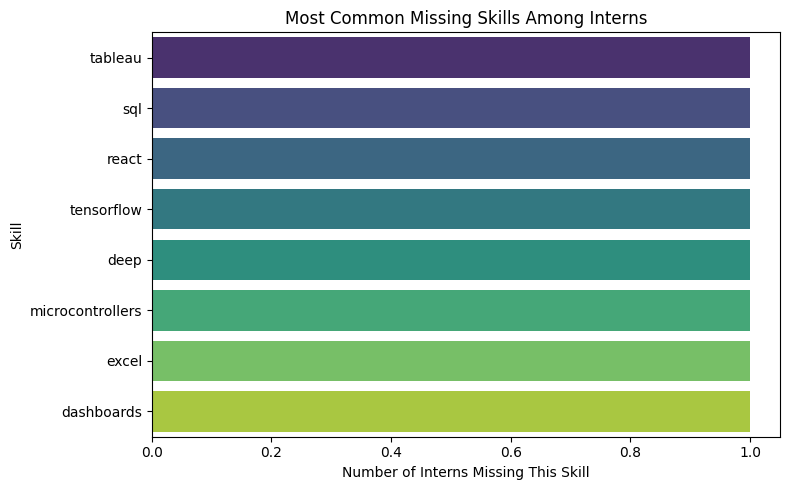

In [16]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Count missing skills across all interns
all_missing = []
for skills in gap_df['Missing Skills']:
    if skills:
        all_missing.extend(skills.split(', '))

# Count frequency
skill_counts = Counter(all_missing)

# Convert to DataFrame and sort
skill_freq_df = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Count']).sort_values(by='Count', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Count', y='Skill', data=skill_freq_df, palette='viridis')
plt.title("Most Common Missing Skills Among Interns")
plt.xlabel("Number of Interns Missing This Skill")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()


In [17]:
# Save results to CSV for report or GitHub
gap_df.to_csv("Intern_Skill_Gap_Report.csv", index=False)

# Preview file
gap_df.head()


,Intern,Intern Skills,Matched Job,Job Requirements,Missing Skills,Suggested Training
0,Ali,"Python, Excel, Data Analysis",Data Analyst,"SQL, Python, Tableau, Excel","tableau, sql",Learn tableau | Learn sql
1,Sara,"HTML, CSS, JavaScript, Java",Web Developer,"HTML, CSS, React, JavaScript",react,Learn react
2,John,"Python, Pandas, Machine Learning",ML Engineer,"Python, TensorFlow, Deep Learning","tensorflow, deep",Learn tensorflow | Learn deep
3,Ayesha,"Arduino, C++, Embedded Systems",Embedded Developer,"Embedded Systems, C++, Microcontrollers",microcontrollers,Learn microcontrollers
4,Imran,"SQL, Power BI, Data Visualization",BI Analyst,"SQL, Power BI, Excel, Dashboards","excel, dashboards",Learn excel | Learn dashboards
